<a href="https://colab.research.google.com/github/GMouraBFR/E-Commerce-/blob/main/E-Commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importando e fazendo Uplound de dados**

In [9]:
import pandas as pd
import zipfile
from google.colab import files

# Fazendo upload do arquivo zip
uploaded = files.upload()



Saving ecommerce_dataset_us.csv to ecommerce_dataset_us (2).csv


# **Ler o Arquivo em Chunks**

In [13]:
# Definir o tamanho do chunk
chunk_size = 10000

# Inicializar um contador de chunks e uma lista para armazenar DataFrames
chunk_list = []

# Ler o arquivo CSV em chunks
try:
    for chunk in pd.read_csv('ecommerce_dataset_us.csv', chunksize=chunk_size, on_bad_lines='skip'):
        # Adicionar cada chunk à lista
        chunk_list.append(chunk)
        # Exibir as primeiras linhas de cada chunk
        print(chunk.head())
except pd.errors.ParserError as e:
    print(f"Erro ao ler o CSV: {e}")

# Combinar os chunks em um único DataFrame
ecommerce_data = pd.concat(chunk_list, ignore_index=True)

# Exibir as primeiras linhas do DataFrame combinado
print(ecommerce_data.head())



  InvoiceNo\tStockCode\tDescription\tQuantity\tInvoiceDate\tUnitPrice\tCustomerID
0  536365\t85123A\tWHITE HANGING HEART T-LIGHT HO...                             
1  536365\t71053\tWHITE METAL LANTERN\t6\t11/29/2...                             
2  536365\t84406B\tCREAM CUPID HEARTS COAT HANGER...                             
3  536365\t84029G\tKNITTED UNION FLAG HOT WATER B...                             
4  536365\t84029E\tRED WOOLLY HOTTIE WHITE HEART....                             
      InvoiceNo\tStockCode\tDescription\tQuantity\tInvoiceDate\tUnitPrice\tCustomerID
10000  537225\tM\tManual\t1\t12/03/2018 16:41\t1.0\t1...                             
10001  537225\t79067\tCORONA MEXICAN TRAY\t1\t12/03/2...                             
10002  537225\t22426\tENAMEL WASH BOWL CREAM\t2\t12/0...                             
10003  537225\t22208\tWOOD STAMP SET THANK YOU\t5\t12...                             
10004  537225\t21446\t12 RED ROSE PEG PLACE SETTINGS\...                      

# **Ler o Arquivo CSV com o Delimitador Correto**
Verificar a Estrutura dos Dados e Tratar Valores Ausentes
Converter 'InvoiceDate' para datetime e Visualizações Iniciais

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID  
0  11/29/2018 08:26       2.55     17850.0  
1  11/29/2018 08:26       3.39     17850.0  
2  11/29/2018 08:26       2.75     17850.0  
3  11/29/2018 08:26       3.39     17850.0  
4  11/29/2018 08:26       3.39     17850.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Descriptio

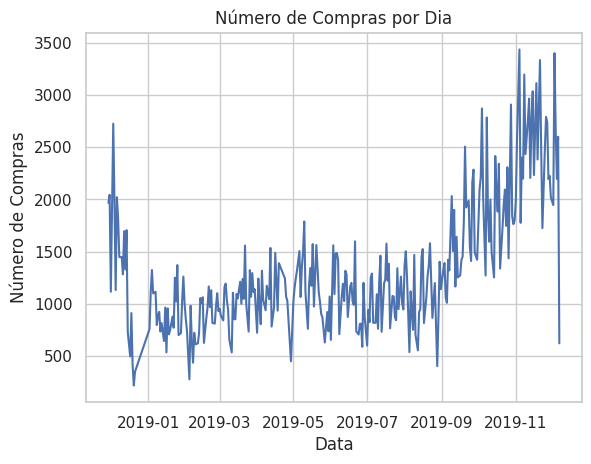

In [15]:
# Ler o arquivo CSV com o delimitador correto
ecommerce_data = pd.read_csv('ecommerce_dataset_us.csv', delimiter='\t')

# Exibir as primeiras linhas do DataFrame para verificar se foi carregado corretamente
print(ecommerce_data.head())

# Verificar a estrutura dos dados
print(ecommerce_data.info())

# Tratar valores ausentes
ecommerce_data.dropna(subset=['CustomerID'], inplace=True)

# Converter 'InvoiceDate' para datetime
ecommerce_data['InvoiceDate'] = pd.to_datetime(ecommerce_data['InvoiceDate'])

# Visualizações iniciais
ecommerce_data['InvoiceDate'].dt.date.value_counts().sort_index().plot(kind='line')
plt.title('Número de Compras por Dia')
plt.xlabel('Data')
plt.ylabel('Número de Compras')
plt.show()



# **Segmentação de Usuários**
Calcular Métricas RFM

Dividir em Quantis e Calcular Pontuação

In [24]:
# Calcular métricas RFM
now = ecommerce_data['InvoiceDate'].max()
rfm = ecommerce_data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (now - x.max()).days,
    'InvoiceNo': 'count',
    'UnitPrice': lambda x: (x * ecommerce_data['Quantity']).sum()
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'UnitPrice': 'Monetary'
})

# Dividir em quantis e calcular pontuação
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])
def rfm_score(x, p, d):
    if x <= p[d][0.25]:
        return 1
    elif x <= p[d][0.50]:
        return 2
    elif x <= p[d][0.75]:
        return 3
    else:
        return 4

rfm['R'] = rfm['Recency'].apply(rfm_score, args=(quantiles, 'Recency'))
rfm['F'] = rfm['Frequency'].apply(rfm_score, args=(quantiles, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(rfm_score, args=(quantiles, 'Monetary'))
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

# Visualizar a segmentação RFM
print(rfm.head())



            Recency  Frequency  Monetary  R  F  M RFM_Score
CustomerID                                                 
12346.0         325          2      0.00  4  1  1       411
12347.0           1        182   4310.00  1  4  4       144
12348.0          74         31   1797.24  3  2  4       324
12349.0          18         73   1757.55  2  3  4       234
12350.0         309         17    334.40  4  1  2       412


# **Visualização das Segmentações**

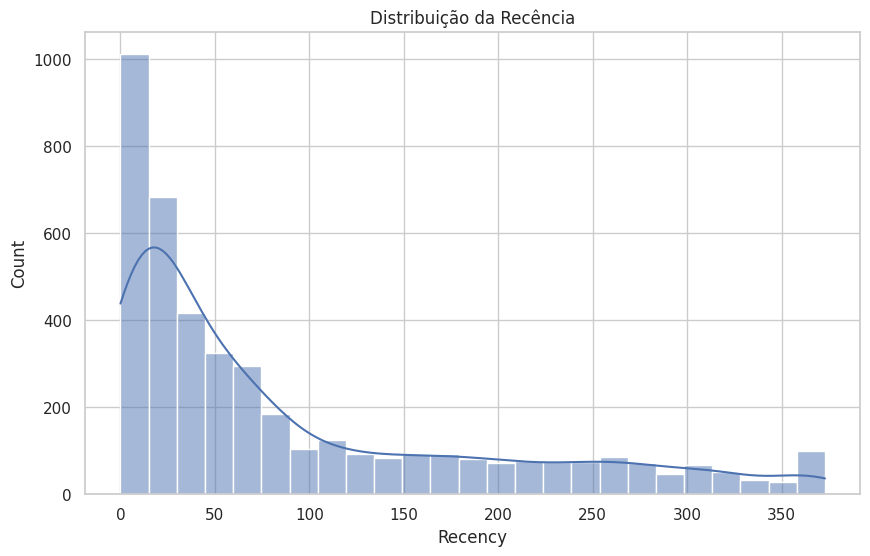

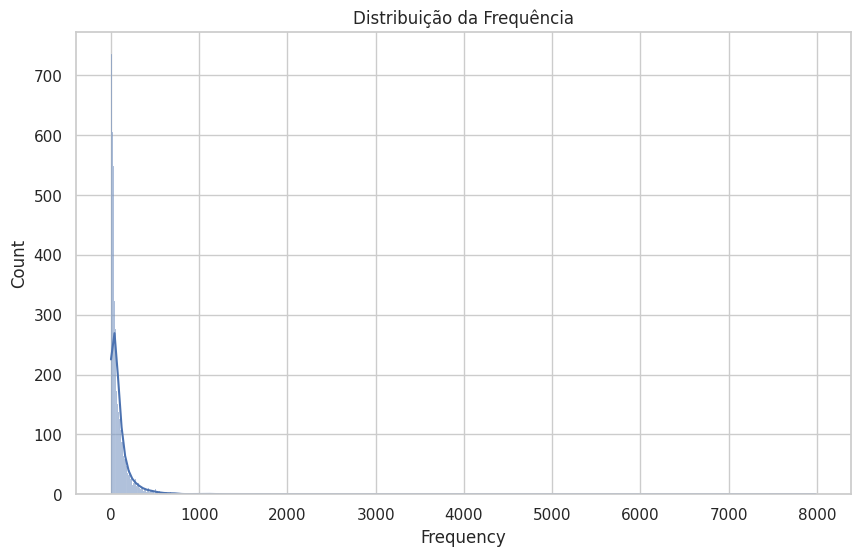

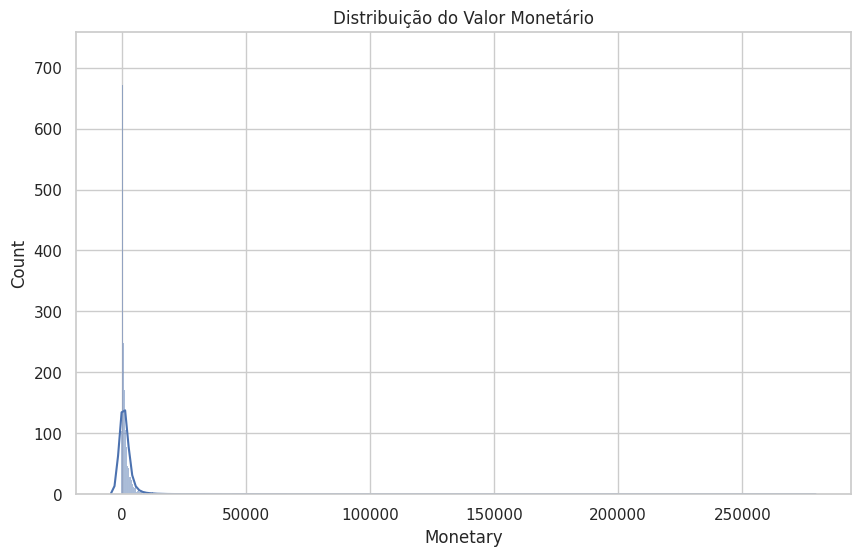

In [18]:
# Visualização das métricas RFM
plt.figure(figsize=(10, 6))
sns.histplot(rfm['Recency'], kde=True)
plt.title('Distribuição da Recência')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(rfm['Frequency'], kde=True)
plt.title('Distribuição da Frequência')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(rfm['Monetary'], kde=True)
plt.title('Distribuição do Valor Monetário')
plt.show()


# **Teste Hipótese**

In [30]:
import numpy as np
import scipy.stats as stats

# Definir grupos com base no número de compras
more_than_10_purchases = rfm[rfm['Frequency'] > 10]['Monetary']
ten_or_less_purchases = rfm[rfm['Frequency'] <= 10]['Monetary']

# Calcular as médias
mean_more_than_10 = more_than_10_purchases.mean()
mean_ten_or_less = ten_or_less_purchases.mean()

print(f"Média do grupo com mais de 10 compras: {mean_more_than_10}")
print(f"Média do grupo com 10 ou menos compras: {mean_ten_or_less}")

# Realizar o teste t de Student para comparar as médias dos dois grupos
t_stat, p_value = stats.ttest_ind(more_than_10_purchases, ten_or_less_purchases, equal_var=False)

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

# Interpretar o resultado
alpha = 0.05
if p_value < alpha:
    print("Rejeitamos a hipótese nula. Há uma diferença significativa na média das compras entre os dois grupos.")
else:
    print("Falha em rejeitar a hipótese nula. Não há uma diferença significativa na média das compras entre os dois grupos.")


Média do grupo com mais de 10 compras: 2185.703901807391
Média do grupo com 10 ou menos compras: 297.23526315789474
t-statistic: 12.676997954094785
p-value: 3.9298238610573456e-36
Rejeitamos a hipótese nula. Há uma diferença significativa na média das compras entre os dois grupos.
